# Generate Dataframe of Incident Status Information

pwd

In [1]:
cd ..

e:\two_stage_model\data_processing


In [2]:
import geopandas as gpd
import pandas as pd
import pickle
import datetime
import numpy as np
import glob
import os

from datetime import datetime as dt
from shapely.geometry import Point
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from bisect import bisect_left

In [3]:
country_name = 'TSMO'
model_path = 'E:/two_stage_model'
# Hyperparamter
# Time
start_date = dt(2022, 2, 14)
end_date = dt(2023, 2, 12)
start_time = 330 # 05:30:00 
end_time = 1260 # 21:00:00
busi_date = pd.bdate_range(start=start_date, end=end_date).date  # 260 business dates
datetime_index = pd.bdate_range(start=start_date, end=end_date+datetime.timedelta(days=1),freq="5min")
upstream_range_mile = 0.3
downstream_range_mile = 1
minimum_abnormal_sd_length = 3 # every 5 min, meaning larger than 15 min regard as incident

# 1. Merage Data into one csv file
### Attention! Only Excute this block if {country_name}_df_inc_raw.pkl is not in this folder

In [4]:
merged_inc_dfs = []

In [5]:
incident_files = glob.glob(f'{model_path}/data/{country_name}/incident_raw' + '/*.csv')

In [6]:
for file_path in incident_files:
    single_inc_df = pd.read_csv(file_path)
    merged_inc_dfs.append(single_inc_df)

In [7]:
merged_inc_df_raw = pd.concat(merged_inc_dfs, axis=0)

In [8]:
merged_inc_df_raw

,Event ID,System,Agency,Standardized Type,Agency-specific Type,Agency-specific Sub Type,Start time,Closed time,Open/Closed,Location,...,Longitude,Road,Direction,County,State,Duration (Incident clearance time),Max Lanes Closed,Reliability Score,Confidence Score,User Report Rating
0,WAZE_0184b74f-b75b-4450-b19a-114ab8fc0ff3,Waze,Waze,Collision,Accident,Accident Minor,2022-02-16T17:53:42-05:00,2022-02-16T18:05:02-05:00,Closed,I-695,...,-76.698454,I-695,North,Baltimore,Maryland,11 minutes,NaN,10.0,1.0,4.0
1,WAZE_173d674d-471c-43ff-bf51-fe0ef4463a58,Waze,Waze,Collision,Accident,Accident Major,2022-02-16T07:42:38-05:00,2022-02-16T08:14:49-05:00,Closed,MD-97,...,-76.996757,MD 97,North,Carroll,Maryland,32 minutes,NaN,6.0,0.0,4.0
2,WAZE_18631f68-0611-4896-8f84-a584e3adef19,Waze,Waze,Collision,Accident,Accident Minor,2022-02-16T16:32:11-05:00,2022-02-16T17:19:57-05:00,Closed,I-49B,...,-76.679234,I-49,West,Baltimore,Maryland,47 minutes,NaN,10.0,3.0,0.0
3,WAZE_20c103f0-b3d3-4252-adc8-0d838e9a02d3,Waze,Waze,Collision,Accident,Accident Minor,2022-02-16T08:15:36-05:00,2022-02-16T09:14:25-05:00,Closed,I-695,...,-76.520340,I-695,West,Baltimore,Maryland,58 minutes,NaN,10.0,4.0,3.0
4,WAZE_240280b6-59e0-4942-b8b0-35f5bf41f9a1,Waze,Waze,Collision,Accident,Accident Minor,2022-02-16T20:01:37-05:00,2022-02-16T20:34:34-05:00,Closed,WATERLOO RD,...,-76.778175,WATERLOO RD,NaN,Howard,Maryland,32 minutes,NaN,6.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8503,MDOT_CHART_feffcba61a1408a60063d32ec4235c0a,MDOT CHART,MDDOT,Disabled Vehicle,Disabled Vehicle,NaN,2022-12-23T15:50:46-05:00,2022-12-23T16:11:24-05:00,Closed,I-70 WEST AT EXIT 87A US 29 COLUMBIA PIKE (WB),...,-76.817592,I-70,West,Howard,Maryland,20 minutes,NaN,NaN,NaN,NaN
8504,MDOT_CHART_ff0025e0277e069e0063d32ec4235c0a,MDOT CHART,MDDOT,Disabled Vehicle,Disabled Vehicle,NaN,2022-12-17T21:45:52-05:00,2022-12-17T22:01:59-05:00,Closed,I-83 NORTH AT EXIT 16A TIMONIUM RD (NB),...,-76.633392,I-83,North,Baltimore,Maryland,16 minutes,NaN,NaN,NaN,NaN
8505,MDOT_CHART_ff002d966f630aaf0063d32ec4235c0a,MDOT CHART,MDDOT,Collision,Incident,NaN,2022-12-30T17:17:58-05:00,2022-12-30T18:08:51-05:00,Closed,I-83 NORTH AT EXIT 16A TIMONIUM RD (NB),...,-76.633392,I-83,North,Baltimore,Maryland,50 minutes,5.0,NaN,NaN,NaN
8506,MDOT_CHART_ff00332c202108a60063d32ec4235c0a,MDOT CHART,MDDOT,Obstructions,Incident,NaN,2022-12-23T16:44:12-05:00,2022-12-23T16:44:23-05:00,Closed,I-695 INNER LOOP PRIOR TO EXIT 44 MD 695 BROEN...,...,-76.508928,I-695,Inner loop,Baltimore,Maryland,11 seconds,NaN,NaN,NaN,NaN


In [9]:
print('Incident Type Includes', list(set(merged_inc_df_raw['Standardized Type'])))
print('Agency-specific Type Includes', list(set(merged_inc_df_raw['Agency-specific Type'])))
print('Agency-specific Sub Type Includes', list(set(merged_inc_df_raw['Agency-specific Sub Type'])))
print('Incident Source Includes', list(set(merged_inc_df_raw['System'])))
print('Column Includes', list(set(merged_inc_df_raw.columns)))
print('Country Includes', list(set(merged_inc_df_raw['County'])))

Incident Type Includes ['Collision', 'Vehicle On Fire', 'Flood', 'Disabled Vehicle', 'Obstructions', 'Injuries Involved', 'Medical Emergency', 'Emergency Roadwork', 'Traffic Congestion', 'Incident', 'Weather Condition']
Agency-specific Type Includes ['Weatherhazard', 'Disabled Vehicle', 'Accident', 'Congestion', 'Incident']
Agency-specific Sub Type Includes ['Hazard Weather Heavy Snow', nan, 'Accident Minor', 'Hazard Weather Flood', 'Accident Major']
Incident Source Includes ['Waze', 'MDOT CHART']
Column Includes ['Max Lanes Closed', 'Agency-specific Type', 'Event ID', 'Open/Closed', 'Location', 'Start time', 'Confidence Score', 'User Report Rating', 'System', 'Agency-specific Sub Type', 'Longitude', 'Duration (Incident clearance time)', 'Latitude', 'Op. Center', 'Agency', 'Standardized Type', 'Direction', 'Road', 'State', 'County', 'Closed time', 'Reliability Score']
Country Includes ['Baltimore City', 'Baltimore', 'Howard', 'Carroll']


In [10]:
pickle.dump(merged_inc_df_raw, open(f'{model_path}/data_processing/Incident_Manual_Check/{country_name}_df_inc_raw.pkl', "wb"))

# 2. Load Geo and Speed Information

 - load geo information

In [11]:
gdf_tmc_raw = gpd.read_file(f'{model_path}/data/{country_name}/geo_info/{country_name}_tmc_shape_for_sjoin.geojson')
gdf_tmc_raw = gdf_tmc_raw.rename(columns={"tmc":"id_tmc"})


In [12]:
spd_record_all = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_all_from_1_min.pkl", "rb"))

In [13]:
speed_available_tmc_list = list(spd_record_all.columns)

In [14]:
gdf_tmc_all = gdf_tmc_raw[gdf_tmc_raw['id_tmc'].isin(speed_available_tmc_list)]

In [15]:
gdf_tmc_all_polygon = gdf_tmc_all.copy()
gdf_tmc_all_polygon["geometry"] = gdf_tmc_all.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)

# 3 Process Incident Dataframe
 - load incident information

In [16]:
merged_inc_df_raw = pickle.load(open(f"{model_path}/data_processing/Incident_Manual_Check/{country_name}_df_inc_raw.pkl", "rb")) 

## 3.1 Clean Date and Time

In [17]:
merged_inc_df_raw = merged_inc_df_raw[~((merged_inc_df_raw["Closed time"].isna()) & (merged_inc_df_raw["Duration (Incident clearance time)"].isna()))] 

In [18]:
merged_inc_df_raw["dt_start"] = merged_inc_df_raw.apply(lambda x: dt.strptime(x["Start time"][:-6], '%Y-%m-%dT%H:%M:%S'), axis=1)
merged_inc_df_raw["dt_end"] = merged_inc_df_raw.apply(lambda x: dt.strptime(x["Closed time"][:-6], '%Y-%m-%dT%H:%M:%S'), axis=1)
merged_inc_df_raw["dt_duration"] = merged_inc_df_raw["dt_end"] - merged_inc_df_raw["dt_start"]

## 3.2 Perform spatial join to map incident location to TMC segment(s)

In [19]:
# Note: gpd.GeoDataFrame() is inplace, so I supply TSMO_df_inc_raw.copy() here
gdf_inc_point = gpd.GeoDataFrame(
                    merged_inc_df_raw.copy(), crs={'init': 'epsg:4326'},
                    geometry=[Point(xy) for xy in zip(merged_inc_df_raw["Longitude"], merged_inc_df_raw["Latitude"])]) # (163140, 34)

c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [20]:
gdf_inc_point = gdf_inc_point[~((gdf_inc_point.Latitude.isna()) | (gdf_inc_point.Longitude.isna()))] # (163139, 34)

<Axes: >

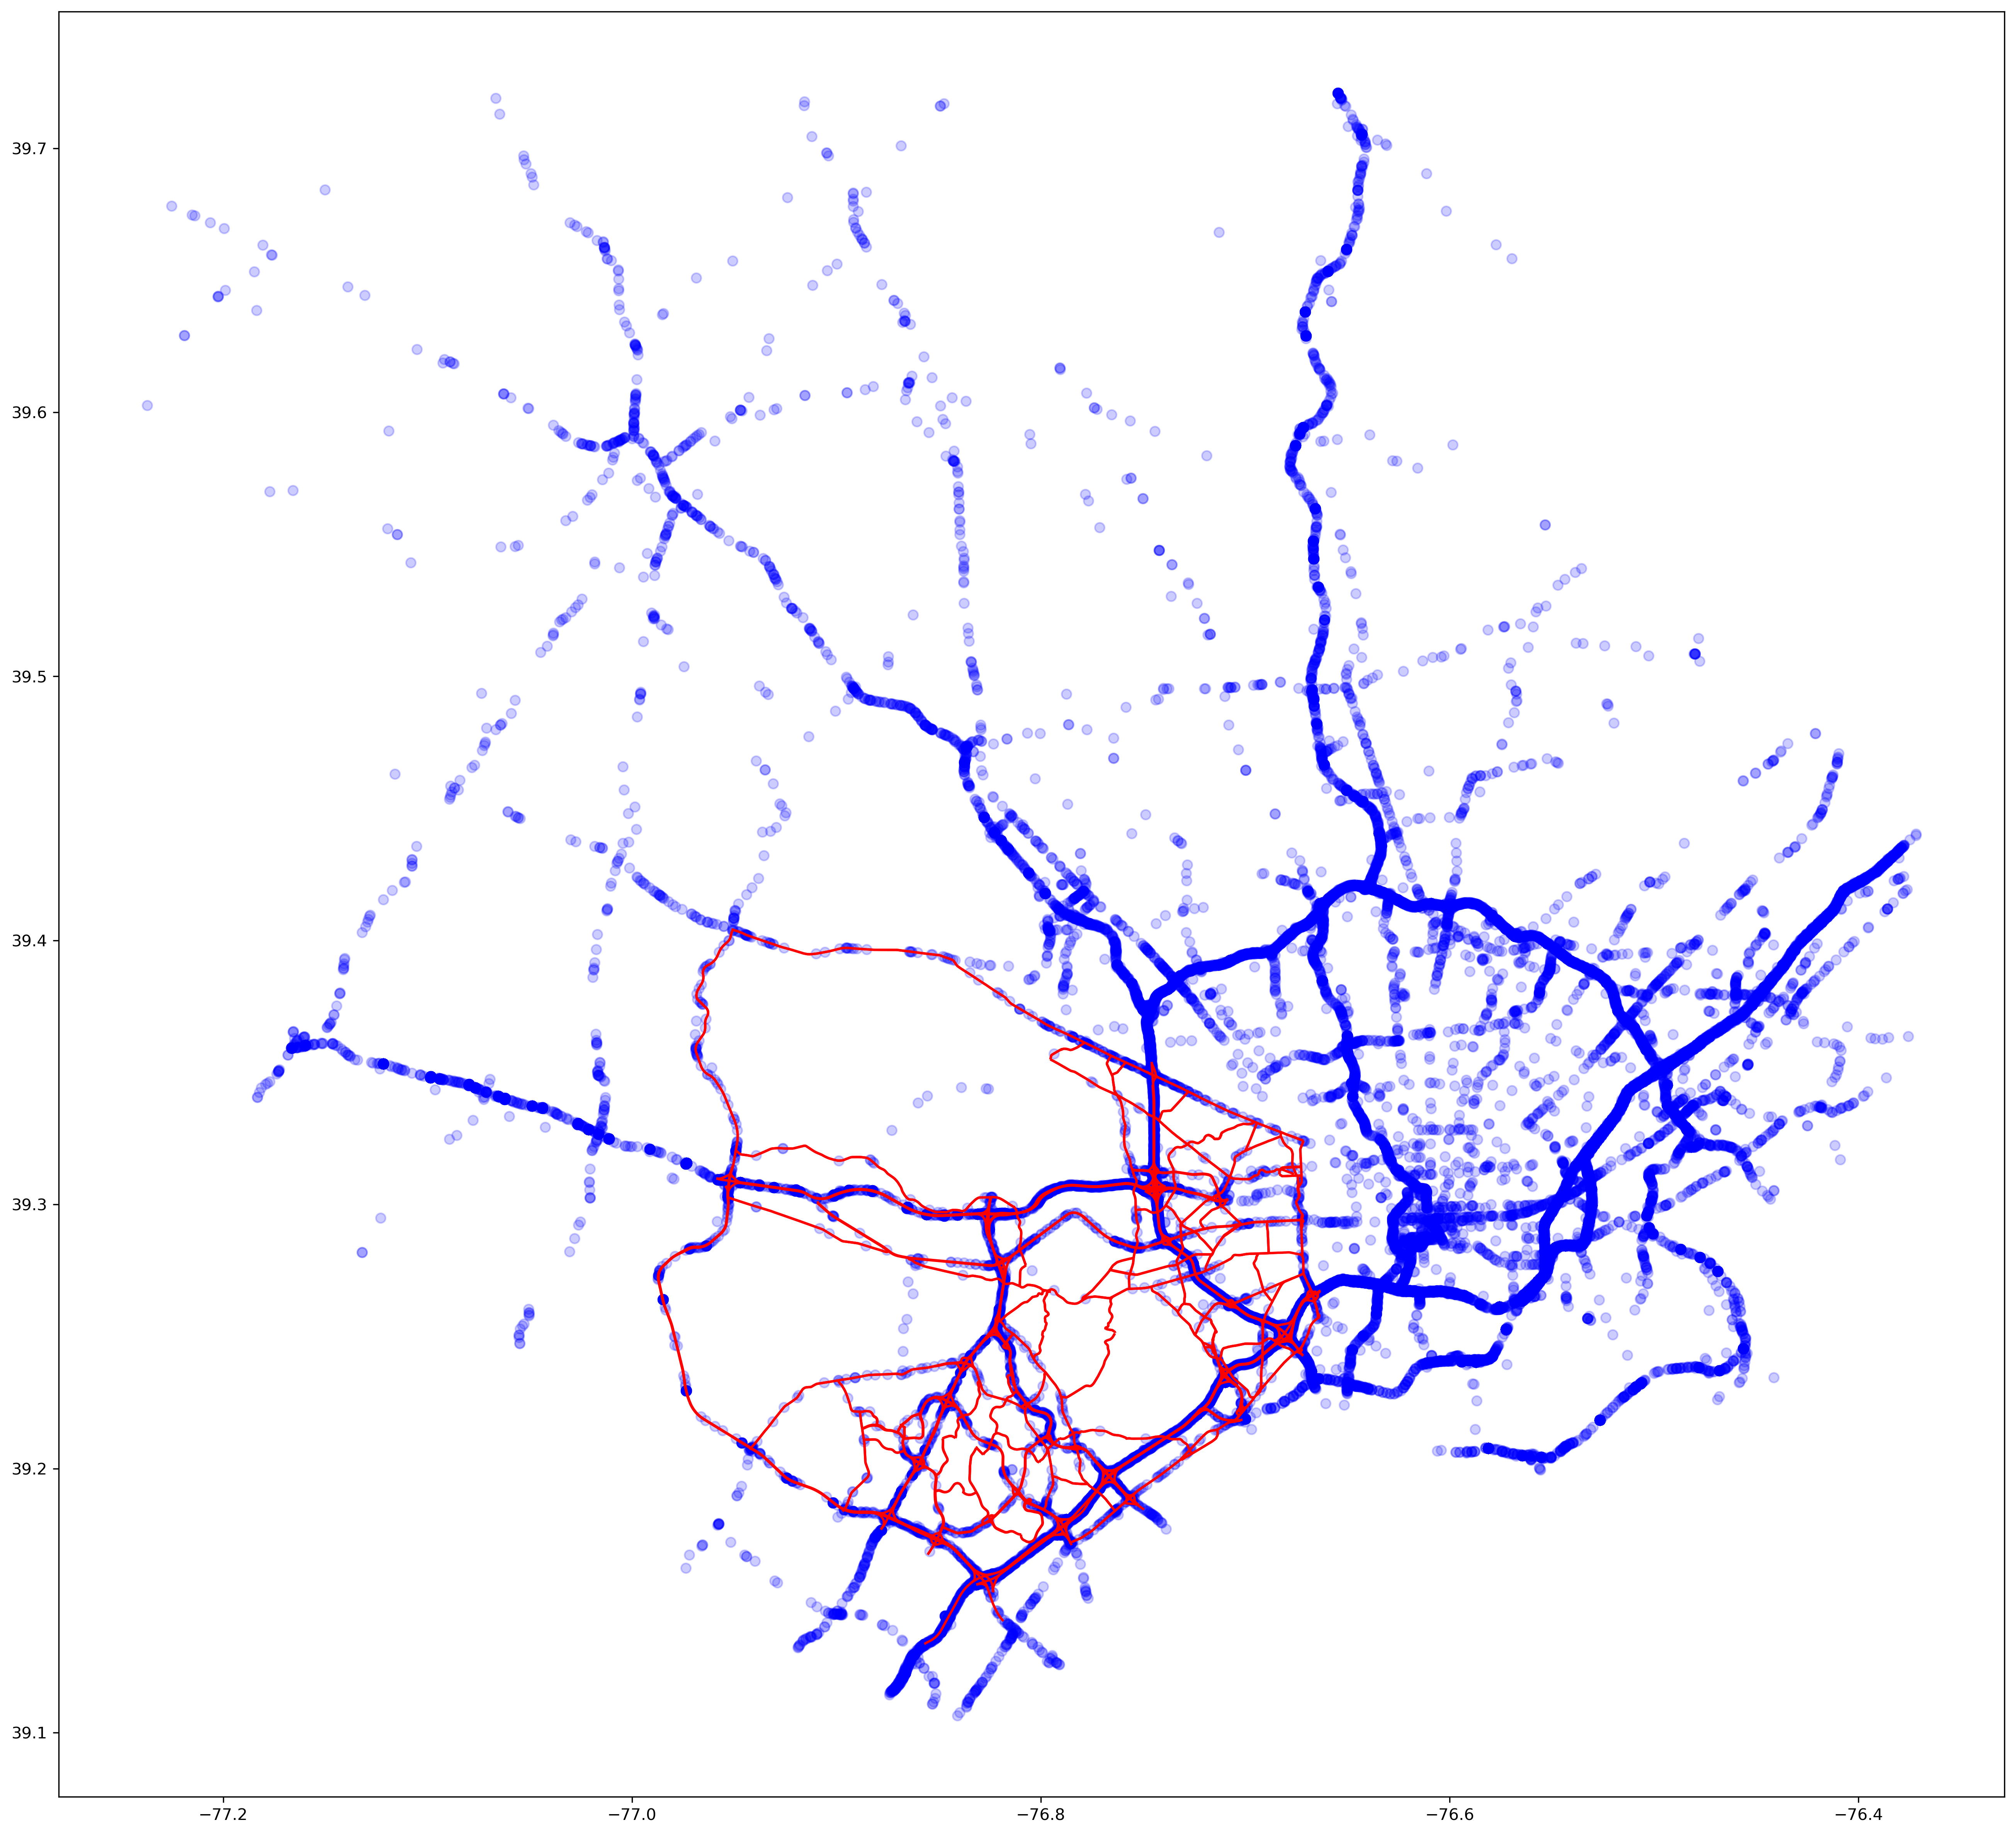

In [21]:
# Visualize Incident Location Points of All Time from Feb 14, 2022 to Feb 12, 2023
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_inc_point.plot(ax=ax, color="blue", alpha=0.2)
gdf_tmc_all.plot(ax=ax, color = "red")

In [22]:
gdf_inc_point_matched_with_tmc = gpd.sjoin(left_df=gdf_inc_point, right_df= gdf_tmc_all_polygon, how="left", op="within")  

c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\haowu\AppData\Local\Temp\ipykernel_427460\1596107103.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  gdf_inc_point_matched_with_tmc = gpd.sjoin(left_df=gdf_inc_point, right_df= gdf_tmc_all_polygon, how="left", op="within")


In [23]:
gdf_inc_record_all_raw = gdf_inc_point_matched_with_tmc[~gdf_inc_point_matched_with_tmc.id_tmc.isna()]  

In [25]:
gdf_inc_record_all_raw

,Event ID,System,Agency,Standardized Type,Agency-specific Type,Agency-specific Sub Type,Start time,Closed time,Open/Closed,Location,...,roadnumber,county,state,zip,start_latitude,start_longitude,end_latitude,end_longitude,layer,path
0,WAZE_0184b74f-b75b-4450-b19a-114ab8fc0ff3,Waze,Waze,Collision,Accident,Accident Minor,2022-02-16T17:53:42-05:00,2022-02-16T18:05:02-05:00,Closed,I-695,...,I-695,BALTIMORE,MD,21227,39.25730,-76.69578,39.26047,-76.70301,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
2,WAZE_18631f68-0611-4896-8f84-a584e3adef19,Waze,Waze,Collision,Accident,Accident Minor,2022-02-16T16:32:11-05:00,2022-02-16T17:19:57-05:00,Closed,I-49B,...,NaN,BALTIMORE,MD,21227,39.25615,-76.67687,39.25450,-76.68237,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
18,WAZE_7011fdce-3ee8-412b-b3f5-c5242e166bdb,Waze,Waze,Collision,Accident,Accident Minor,2022-02-16T15:40:41-05:00,2022-02-16T16:16:50-05:00,Closed,HARPERS FARM RD,...,NaN,HOWARD,MD,21044,39.23316,-76.89893,39.22154,-76.88850,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
18,WAZE_7011fdce-3ee8-412b-b3f5-c5242e166bdb,Waze,Waze,Collision,Accident,Accident Minor,2022-02-16T15:40:41-05:00,2022-02-16T16:16:50-05:00,Closed,HARPERS FARM RD,...,NaN,HOWARD,MD,21029,39.22154,-76.88850,39.23316,-76.89893,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
29,WAZE_d199d9ce-8eb6-4e37-bcce-8a09f1591b60,Waze,Waze,Collision,Accident,Accident Major,2022-02-16T22:23:46-05:00,2022-02-16T22:54:56-05:00,Closed,SNOWDEN RIVER PKWY,...,NaN,HOWARD,MD,20723,39.17754,-76.84740,39.17931,-76.82714,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8479,MDOT_CHART_faff53962993069e0063d32ec4235c0a,MDOT CHART,MDDOT,Disabled Vehicle,Disabled Vehicle,NaN,2022-12-17T23:14:14-05:00,2022-12-17T23:16:22-05:00,Closed,I-95 SOUTH PRIOR TO EXIT 43A MD 100 MD 100 (SB),...,I-95,HOWARD,MD,21075,39.20036,-76.76189,39.19369,-76.77071,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
8480,MDOT_CHART_faff88c0f56a059d0063d32ec4235c0a,MDOT CHART,MDDOT,Collision,Incident,NaN,2022-12-17T02:07:44-05:00,2022-12-17T04:18:19-05:00,Closed,I-95 SOUTH AT EXIT 49A I 695 BALTO BELTWAY (SB),...,I-95,BALTIMORE,MD,21227,39.25615,-76.67687,39.24784,-76.68477,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
8501,MDOT_CHART_feff8507df2c09ad0063d32ec4235c0a,MDOT CHART,MDDOT,Disabled Vehicle,Disabled Vehicle,NaN,2022-12-29T00:56:23-05:00,2022-12-29T00:56:39-05:00,Closed,I-695 OUTER LOOP PRIOR TO EXIT 12B MD 372 WILK...,...,NaN,BALTIMORE,MD,21227,39.26181,-76.70816,39.26217,-76.70759,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
8503,MDOT_CHART_feffcba61a1408a60063d32ec4235c0a,MDOT CHART,MDDOT,Disabled Vehicle,Disabled Vehicle,NaN,2022-12-23T15:50:46-05:00,2022-12-23T16:11:24-05:00,Closed,I-70 WEST AT EXIT 87A US 29 COLUMBIA PIKE (WB),...,I-70,HOWARD,MD,21043,39.29666,-76.81462,39.29660,-76.83091,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...


## 3.3. Finalize Spatial-temporal Dataframe of Incident Status
-Make spatial-temporal dataframe of incident status

In [26]:
# Make sure start and/or end date falls into business dates
gdf_inc_record_all_filtered_date = gdf_inc_record_all_raw[
    (gdf_inc_record_all_raw.dt_start.dt.date.isin(busi_date)) | (gdf_inc_record_all_raw.dt_end.dt.date.isin(busi_date))
    ]  # (29800, 52)


# Make sure start and/or end time falls into business hours
gdf_inc_record_all_filtered_date_time = gdf_inc_record_all_filtered_date[
                ((gdf_inc_record_all_filtered_date.dt_start.dt.hour*60 + gdf_inc_record_all_filtered_date.dt_start.dt.minute >= start_time) & (gdf_inc_record_all_filtered_date.dt_start.dt.hour*60 +gdf_inc_record_all_filtered_date.dt_start.dt.minute < end_time)) |
                ((gdf_inc_record_all_filtered_date.dt_end.dt.hour*60 + gdf_inc_record_all_filtered_date.dt_end.dt.minute >= start_time) & (gdf_inc_record_all_filtered_date.dt_end.dt.hour*60 + gdf_inc_record_all_filtered_date.dt_end.dt.minute < end_time)) 
            ]  # (26984, 52)

In [27]:
gdf_inc_record_all_filtered_date_time = gdf_inc_record_all_filtered_date_time[gdf_inc_record_all_filtered_date_time.dt_start.dt.date == gdf_inc_record_all_filtered_date_time.dt_end.dt.date]

In [28]:
gdf_inc_record_all_filtered_date_time

,Event ID,System,Agency,Standardized Type,Agency-specific Type,Agency-specific Sub Type,Start time,Closed time,Open/Closed,Location,...,roadnumber,county,state,zip,start_latitude,start_longitude,end_latitude,end_longitude,layer,path
0,WAZE_0184b74f-b75b-4450-b19a-114ab8fc0ff3,Waze,Waze,Collision,Accident,Accident Minor,2022-02-16T17:53:42-05:00,2022-02-16T18:05:02-05:00,Closed,I-695,...,I-695,BALTIMORE,MD,21227,39.25730,-76.69578,39.26047,-76.70301,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
2,WAZE_18631f68-0611-4896-8f84-a584e3adef19,Waze,Waze,Collision,Accident,Accident Minor,2022-02-16T16:32:11-05:00,2022-02-16T17:19:57-05:00,Closed,I-49B,...,NaN,BALTIMORE,MD,21227,39.25615,-76.67687,39.25450,-76.68237,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
18,WAZE_7011fdce-3ee8-412b-b3f5-c5242e166bdb,Waze,Waze,Collision,Accident,Accident Minor,2022-02-16T15:40:41-05:00,2022-02-16T16:16:50-05:00,Closed,HARPERS FARM RD,...,NaN,HOWARD,MD,21044,39.23316,-76.89893,39.22154,-76.88850,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
18,WAZE_7011fdce-3ee8-412b-b3f5-c5242e166bdb,Waze,Waze,Collision,Accident,Accident Minor,2022-02-16T15:40:41-05:00,2022-02-16T16:16:50-05:00,Closed,HARPERS FARM RD,...,NaN,HOWARD,MD,21029,39.22154,-76.88850,39.23316,-76.89893,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
34,WAZE_f3fedafb-90fe-4bb3-ae1f-4be12e5189f7,Waze,Waze,Collision,Accident,Accident Major,2022-02-16T12:37:18-05:00,2022-02-16T13:10:50-05:00,Closed,I-695,...,I-695,BALTIMORE,MD,21228,39.28854,-76.74088,39.28431,-76.73571,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8470,MDOT_CHART_f90026620918059a0063d32ec4235c0a,MDOT CHART,MDDOT,Vehicle On Fire,Incident,NaN,2022-12-14T13:39:30-05:00,2022-12-14T13:59:05-05:00,Closed,I-95 SOUTH AT EXIT 35B MD 216 SCAGGSVILLE RD (SB),...,I-95,HOWARD,MD,20707,39.15663,-76.83416,39.13357,-76.85698,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
8471,MDOT_CHART_f9005b01fe4606a20063d32ec4235c0a,MDOT CHART,MDDOT,Vehicle On Fire,Incident,NaN,2022-12-20T18:32:17-05:00,2022-12-20T19:15:42-05:00,Closed,I-95 NORTH AT EXIT 47A I 195 I-195 E (NB),...,NaN,BALTIMORE,MD,21075,39.23043,-76.71385,39.23277,-76.70956,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
8473,MDOT_CHART_f9fe81cf94be06a00063d32ec4235c0a,MDOT CHART,MDDOT,Disabled Vehicle,Disabled Vehicle,NaN,2022-12-19T14:43:11-05:00,2022-12-19T14:45:22-05:00,Closed,I-70 at Patapsco River Br.,...,I-70,BALTIMORE,MD,21207,39.29597,-76.81767,39.30751,-76.75494,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...
8503,MDOT_CHART_feffcba61a1408a60063d32ec4235c0a,MDOT CHART,MDDOT,Disabled Vehicle,Disabled Vehicle,NaN,2022-12-23T15:50:46-05:00,2022-12-23T16:11:24-05:00,Closed,I-70 WEST AT EXIT 87A US 29 COLUMBIA PIKE (WB),...,I-70,HOWARD,MD,21043,39.29666,-76.81462,39.29660,-76.83091,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...


In [29]:
pickle.dump(gdf_inc_record_all_filtered_date_time, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_raw_waze_inc_eval.pkl", "wb"))

In [30]:
df_inc = pd.DataFrame(data=0.0,index=datetime_index,columns=list(set(gdf_tmc_raw.id_tmc))) 

In [31]:
df_inc = df_inc[
        (pd.to_datetime(df_inc.index.date).isin(busi_date)) &   # be careful about the syntax here, dealing with index filtering is really annoying
        (df_inc.index.hour*60 + df_inc.index.minute >= start_time) &
        (df_inc.index.hour*60 + df_inc.index.minute < end_time) 
    ] 

In [32]:
df_inc

,110+05224,110P04517,110P55662,110P54866,110P04389,110+52783,110P12732,110P53838,110-12552,110-11762,...,110P12355,110+53861,110+12754,110P10263,110+05036,110P11795,110P50428,110N11791,110P09566,110P12380
2022-02-14 05:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-14 05:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-14 05:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-14 05:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-14 05:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 20:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-10 20:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-10 20:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-10 20:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
def earliest_time_for_date(index, date_str):
    filtered_times = index[index.date == pd.Timestamp(date_str).date()]
    return filtered_times.min()

In [35]:
def find_earlier_time(time_list, query_time):
    position = bisect_left(time_list, query_time)
    if time_list[position-1].date()!=query_time.date():
        return earliest_time_for_date(time_list, query_time.date()) if position < len(time_list) else None
    else:
        return time_list[position-1] # if position else None

In [36]:
def latest_time_for_date(index, date_str):
    filtered_times = index[index.date == pd.Timestamp(date_str).date()]
    return filtered_times.max()

In [37]:
def find_later_time(time_list, query_time):
    position = bisect_left(time_list, query_time)
    if position < len(time_list):
        if time_list[position].date()!=query_time.date():
            return latest_time_for_date(time_list, query_time.date()) if position < len(time_list) else None
        else:
            return time_list[position]  
    else:
        return max(time_list)

In [38]:
for i in tqdm(range(len(gdf_inc_record_all_filtered_date_time))):
    start = gdf_inc_record_all_filtered_date_time.iloc[i].dt_start
    end = gdf_inc_record_all_filtered_date_time.iloc[i].dt_end
    id_tmc = gdf_inc_record_all_filtered_date_time.iloc[i].id_tmc

    # print(find_later_time(df_inc.index, end), end)
    if find_earlier_time(df_inc.index, start).date() != start.date() or find_later_time(df_inc.index, end).date() != end.date() or find_later_time(df_inc.index, end).date() != find_earlier_time(df_inc.index, start).date():
        print(gdf_inc_record_all_filtered_date_time.iloc[i])

  0%|          | 0/12071 [00:00<?, ?it/s]

100%|██████████| 12071/12071 [00:11<00:00, 1006.86it/s]


In [43]:
for i in tqdm(range(len(gdf_inc_record_all_filtered_date_time))):
    start = gdf_inc_record_all_filtered_date_time.iloc[i].dt_start
    end = gdf_inc_record_all_filtered_date_time.iloc[i].dt_end
    id_tmc = gdf_inc_record_all_filtered_date_time.iloc[i].id_tmc
    # df_inc_waze[(df_inc_waze.index >= start) & (df_inc_waze.index < end)][id_tmc] = 1.0 # this won't work as it will return a view instead of changing value in place
    df_inc.loc[find_earlier_time(df_inc.index, start): find_later_time(df_inc.index, end), id_tmc] = 1.0
    if i == 0: # demo the incident labelling rule
        print('report starts at', start)
        print('we start labelling at', find_earlier_time(df_inc.index, start))
        print('report ends at', end)
        print('we end labelling at', find_later_time(df_inc.index, end))

  2%|▏         | 228/12071 [00:00<00:10, 1146.03it/s]

report starts at 2022-02-16 17:53:42
we start labelling at 2022-02-16 17:50:00
report ends at 2022-02-16 18:05:02
we end labelling at 2022-02-16 18:10:00


100%|██████████| 12071/12071 [00:09<00:00, 1339.42it/s]


In [39]:
df_inc

,110+05224,110P04517,110P55662,110P54866,110P04389,110+52783,110P12732,110P53838,110-12552,110-11762,...,110P12355,110+53861,110+12754,110P10263,110+05036,110P11795,110P50428,110N11791,110P09566,110P12380
2022-02-14 05:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-14 05:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-14 05:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-14 05:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-14 05:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 20:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-10 20:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-10 20:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-10 20:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
np.count_nonzero(df_inc)

101123

In [44]:
pickle.dump(df_inc, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_raw_Waze.pkl", "wb"))